# 训练RNN模拟一个工作记忆任务并进行动态系统分析

## 安装neurogym

In [1]:
# # If on Google Colab, uncomment to install neurogym to use cognitive tasks
# ! git clone https://github.com/gyyang/neurogym.git
# %cd neurogym/
# ! pip install -e .

## 定义一个工作记忆任务

2
3


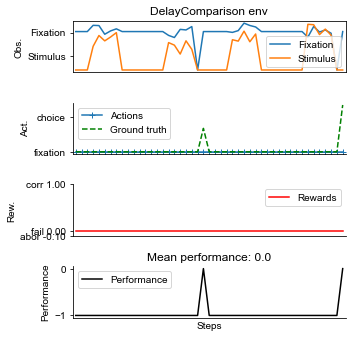

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import neurogym as ngym

# 利用neurogym构建实验环境
# 这个DelayComparision范式来自于1999年的一篇Nature文章
# Romo, R., Brody, C. D., Hernández, A., & Lemus, L. (1999). Nature, 399(6735), 470–473. doi:10.1038/20939
# 在这个实验中，猴子的一只手的手指需要感受来自机械探头的震动
# 猴子一只手的手指接触机械探头，另一只手需要放在一个固定的按键上
# 然后产生一个频率a的震动刺激1（500ms），
# 经过一段时间的delay之后，产生一个频率b的震动刺激2(500ms)
# 刺激2结束后放在固定按键上的手需要释放，然后进行2选1的按键按压
# 选择刺激1和刺激2哪个刺激震动频率更高
# neurogym内置了DelayComparison任务，只需要设定一些参数即可生成
task = 'DelayComparison-v0'
# 设定实验任务相关条件
# delay时长为200ms或400ms或800ms或1600ms或3200ms
# 固定的反应时长为500ms
# 一个时间点对应100ms
# 序列长度为100个时间点（即10000ms）
timing = {'delay': ('choice', [200, 400, 800, 1600, 3200]),
          'response': ('constant', 500)
         }
kwargs = {'dt': 100, 'timing': timing}
seq_len = 100

# 构建任务数据集，传入上述相关参数
# batch_size=16代表生成16个序列
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# 获取数据集的环境信息
env = dataset.env

# 可视化该环境下的两个试次
ngym.utils.plot_env(env, num_trials=2, def_act=0, ob_traces=["Fixation", "Stimulus"])
# 首先是Obs.图，表示被试对特定环境的观测值，这里包含两个维度- Stimulus和Fixation
# 其中由于第二个刺激呈现后猴子需要释放按键，所以每次第二个刺激呈现后，Fixation值都会降为0又重新上升
# Act.图中设定了def_act=0即默认不动，而Ground Truth代表实际应该进行的反应（即正确的反应）
# 即每次释放按键后的判断阶段都需要一个反应选择
# 此实验中无设置奖励条件，因而Rew.图不变
# Performance图表示每个试次的表现

# 网络输入和输出的size
# 在gym里，observation_space由Space.Box类表示，action_space由Space.Discrete类表示
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
# input_size为2，output_size为3

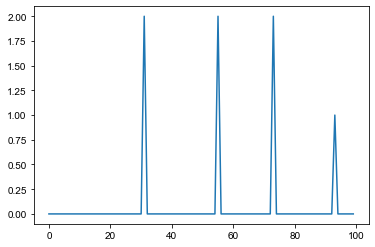

In [4]:
# 获取数据集的inputs和target
inputs, target = dataset()
mask = target > 0
# shape of inputs: N_time * batch_size * N_neuron
#                  即[100, 16, 2]
#                  这里的2，第一个维度为fixation，第二个维度为stimulus
# shape of target: N_time*batch_size
#                  即[100, 16]
# target即为反应（choice），0、1、2分别代表不反应、刺激1频率更高或刺激2频率更高
# 可视化第一个序列的反应
plt.plot(target[:, 0])

## 定义RNN

构建迭代模型：
\begin{align}
    \tau \frac{d\mathbf{h}}{dt} = -\mathbf{h}(t) + f(W_h \mathbf{h}(t) + W_x \mathbf{x}(t) + \mathbf{b}_h).
\end{align}

使用欧拉方法计算每$\Delta t$个时间步长的状态变化, 
\begin{align}
    \mathbf{h}(t+\Delta t) = \mathbf{h}(t) + \Delta \mathbf{h} = \mathbf{h}(t) + \frac{\Delta t}{\tau}[-\mathbf{h}(t) + f(W_h \mathbf{h}(t) + W_x \mathbf{x}(t) + \mathbf{b}_h)].
\end{align}

In [5]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
    

class CTRNN(nn.Module):
    """Continuous-time RNN.

    参数：
        input_size: 输入的神经元数量
        hidden_size: 隐藏层神经元数量

    输入:
        input: 网络输入，序列长度*序列数*输入的神经元数量 即（seq_len, batch, input_size）
        hidden: 初始的隐藏层活动，序列数*隐藏层神经元数量 即 (batch, hidden_size)
    """

    # 构造函数
    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        
        # 调用父类构造函数
        super().__init__()
        
        # 输入数据的维数（输入的神经元数量）
        self.input_size = input_size
        # 隐藏层的维数（隐藏层神经元数量）
        self.hidden_size = hidden_size
        # 定义时间常数tau为100
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        
        # 输入到进入隐藏层，数据通过input_size到hidden_size线性变换
        self.input2h = nn.Linear(input_size, hidden_size)
        # 隐藏层自连接过程，数据通过hidden_size到hidden_size线性变换
        self.h2h = nn.Linear(hidden_size, hidden_size)

    # 初始化隐藏层
    def init_hidden(self, input_shape):
        # 获取输入的序列数
        batch_size = input_shape[1]
        # 初始化隐藏层神经元（全为0）
        return torch.zeros(batch_size, self.hidden_size)

    # 循环计算
    def recurrence(self, input, hidden):
        # 前一时刻的激活
        pre_activation = self.input2h(input) + self.h2h(hidden)
        # 依据欧拉方法计算新时刻的隐藏层状态
        h_new = torch.relu(hidden * self.oneminusalpha +
                           pre_activation * self.alpha)
        # 返回新时刻的隐藏层状态
        return h_new

    # 传入计算
    def forward(self, input, hidden=None):
        # 一开始传入输入
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)
        
        # 定义输出
        output = []
        # 生成步长序列 - 依据序列长度（这里是100个时间点）
        steps = range(input.size(0))
        # 逐步循环计算
        for i in steps:
            # 输入当前时间点的输入与隐藏层状态到recurrence方法
            # 获取新的隐藏层状态
            hidden = self.recurrence(input[i], hidden)
            # 新的隐藏层状态添加到输出变量中
            output.append(hidden)
        # output的shape为 时间点数（100）*序列数（16）*隐藏层神经元数（64）
        output = torch.stack(output, dim=0)
        # 返回ouput和hidden
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    参数:
        input_size
        hidden_size
        output_size: int, output size
        rnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # 连续时间的RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        # 建立隐藏层到输出之间的线性连接
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 获取每个时间点的状态
        # rnn_activity的shape是100 * 16 * 64
        rnn_activity, _ = self.rnn(x)
        # 计算最终输入out
        out = self.fc(rnn_activity)
        # 返回最终RNN的输出和每时间点的活动（即rnn_activity）
        return out, rnn_activity

## 训练RNN

In [11]:
import torch.optim as optim

# 实例化一个RNN网络并打印出网络信息
# 设置64个隐藏层神经元
hidden_size = 64
# 实例化一个RNN
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
# 打印RNN网络模型信息
print(net)

# 使用Adam优化器
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# 初始化loss和acc
running_loss = 0
running_acc = 0
# 进行2000次迭代训练
for i in range(2000):
    # 获取数据输入与标签
    # inputs的shape为[100, 16, 2]
    # labels_np的shape为[100, 16]
    inputs, labels_np = dataset()
    # labels_np铺平为[1600]
    labels_np = labels_np.flatten()
    # numpy类型数据转为torch类型数据
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels_np).type(torch.long)

    # 梯度初始化为0
    optimizer.zero_grad()
    # 获取输出output，其shape为[100, 16, 3]
    output, _ = net(inputs)
    # output的shape转成[1600, 3]
    output = output.view(-1, output_size)
    # 该次迭代的loss
    loss = criterion(output, labels)
    # 反向传播
    loss.backward()
    # 更新权重
    optimizer.step()

    # 获取累计loss
    running_loss += loss.item()
    # 计算表现
    # 首先获取三个维度上输出的最大值对应的维度，对应即为RNN预测的反应
    output_np = np.argmax(output.detach().numpy(), axis=-1)
    # 仅分析非fixation阶段的时间
    ind = labels_np > 0
    # 匹配实际反应与预测反应以计算准确率
    running_acc += np.mean(labels_np[ind] == output_np[ind])
    # 每迭代100步打印一次Loss和Acc
    if i % 100 == 99:
        running_loss /= 100
        running_acc /= 100
        print('Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(i+1, running_loss, running_acc))
        running_loss = 0
        running_acc = 0

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=2, out_features=64, bias=True)
    (h2h): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Step 100, Loss 0.1915, Acc 0.002
Step 200, Loss 0.0546, Acc 0.377
Step 300, Loss 0.0298, Acc 0.703
Step 400, Loss 0.0236, Acc 0.751
Step 500, Loss 0.0189, Acc 0.802
Step 600, Loss 0.0176, Acc 0.812
Step 700, Loss 0.0141, Acc 0.854
Step 800, Loss 0.0125, Acc 0.877
Step 900, Loss 0.0118, Acc 0.879
Step 1000, Loss 0.0105, Acc 0.889
Step 1100, Loss 0.0094, Acc 0.904
Step 1200, Loss 0.0086, Acc 0.912
Step 1300, Loss 0.0095, Acc 0.903
Step 1400, Loss 0.0080, Acc 0.915
Step 1500, Loss 0.0072, Acc 0.927
Step 1600, Loss 0.0076, Acc 0.919
Step 1700, Loss 0.0075, Acc 0.920
Step 1800, Loss 0.0072, Acc 0.922
Step 1900, Loss 0.0072, Acc 0.922
Step 2000, Loss 0.0068, Acc 0.927


## 可视化神经活动

生成100个试次，并将其神经活动投射到一个PCA空间上

In [12]:
import numpy as np
import gym

# 设置delay为3000ms
# 重新生成任务环境
kwargs = {'timing': {'delay': ('constant', 3000)}}
env = gym.make(task, **kwargs)
env.reset(no_step=True)
env.timing

# 初始化一些变量
# 生成100个试次
# activity_dict用于存每个trial的rnn_activity
# trial_infos用于存每个trial的试次信息
perf = 0
num_trial = 100
activity_dict = {}
trial_infos = {}
for i in range(num_trial):
    env.new_trial()
    # 获取observation信息和ground_truth
    # ob的shape为[46, 2], gt的shape为[46]
    ob, gt = env.ob, env.gt
    # 将shape为46 * 2的numpy格式的inputs转成shape为46 * 1 * 2的torch格式
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    # action_pred的shape为：[46, 1, 3]
    # rnn_activity的shape为：[46, 1, 64]
    action_pred, rnn_activity = net(inputs)
    # rnn_activity转为numpy格式
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    # 获取delay期间的rnn_activity
    # 即activity_dict[i]的shape为[30, 64]
    activity_dict[i] = rnn_activity[env.start_ind['delay']:env.end_ind['delay']]
    # 获取当前trial的信息
    trial_infos[i] = env.trial.copy()

# 合并100个试次的activity，即activity的shape为[3000, 64]
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)

# 打印前5个trials的信息
for i in range(5):
    print('Trial ', i, trial_infos[i])

Trial  0 {'ground_truth': 1, 'vpair': (22, 14), 'v1': 22, 'v2': 14}
Trial  1 {'ground_truth': 2, 'vpair': (30, 22), 'v1': 22, 'v2': 30}
Trial  2 {'ground_truth': 1, 'vpair': (22, 14), 'v1': 22, 'v2': 14}
Trial  3 {'ground_truth': 1, 'vpair': (22, 14), 'v1': 22, 'v2': 14}
Trial  4 {'ground_truth': 2, 'vpair': (22, 14), 'v1': 14, 'v2': 22}


Text(0, 0.5, 'PC 2')

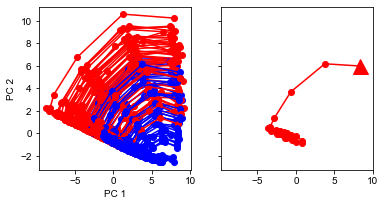

In [13]:
# PCA与可视化
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 实例化一个PCA，计算前2个主成分
pca = PCA(n_components=2)
# 对activity进行PCA
pca.fit(activity)

# 绘制delay阶段的2维PC空间表征
# ground_truth为1的试次为红线，为2的试次为蓝线
# 左图为所有试次的表征，右图为第一个试次的表征，右图中△为起始时间的状态
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trial):
    trial = trial_infos[i]
    activity_pc = pca.transform(activity_dict[i])
    
    color = 'red' if trial['ground_truth'] == 1 else 'blue'
    
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    
    if i < 1:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color, ms=6)
        _ = ax2.plot(activity_pc[0, 0], activity_pc[0, 1], marker='^', color=color, ms=15)
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

## 动力学系统分析

### 寻找近似固定点
在一般动力学系统中：
\begin{align}
    \frac{d\mathbf{x}}{dt} = F(\mathbf{x}),
\end{align}
可以通过一下这种优化方式找到近似固定点：
\begin{align}
    \mathrm{argmin}_{\mathbf{x}} |F(\mathbf{x})|^2.
\end{align}

In [39]:
# 冻结RNN里面的参数
for param in net.parameters():
    param.requires_grad = False

# 设定batch_size为1000
batch_size = 1000

# input为1000 * 1个[1, 0]，即input的shape为[1000, 2]
# 之所以为[1, 0]是因为在delay阶段，fixation维度始终为1，stimulus维度始终为0
input = np.tile([1, 0], (batch_size, 1))
# 转成torch格式
input = torch.tensor(input, dtype=torch.float32)

# 隐藏层活动作为变量进行优化
# 即输入不同的隐藏层活动作为动力学系统的起始点来找每条运动轨迹下的近似固定点
# 随机产生1000个隐藏层活动，这里的方法是：
# 随机抽取1000个隐藏层活动，即从activity的3000个时间点中抽取1000个
# hidden_init的shape为[1000, 64]
# 再对矩阵里的每一个值乘以一个0.5-1.5之间的随机数
hidden_init = activity[np.random.randint(activity.shape[0], size=(batch_size,))]
hidden_init = np.random.uniform(0.5, 1.5, size=hidden_init.shape) * hidden_init
hidden = torch.tensor(hidden_init, requires_grad=True, dtype=torch.float32)

# 使用Adam优化器
optimizer = optim.Adam([hidden], lr=0.01)
criterion = nn.MSELoss()

# 初始化loss
running_loss = 0
# 进行1000次迭代
for i in range(10000):
    # 梯度初始化为0
    optimizer.zero_grad()
    
    # 调用训练好RNN模型的recurrence方法得到新的隐藏层活动
    new_h = net.rnn.recurrence(input, hidden)
    # 计算前后两hidden之间的loss
    loss = criterion(new_h, hidden)
    # 反向传播
    loss.backward()
    # 更新权重
    optimizer.step()
    
    # 每1000步打印一次Loss
    running_loss += loss.item()
    if i % 1000 == 999:
        running_loss /= 1000
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

Step 1000, Loss 2645.7958
Step 2000, Loss 28.6398
Step 3000, Loss 9.6659
Step 4000, Loss 7.2979
Step 5000, Loss 5.7376
Step 6000, Loss 3.9795
Step 7000, Loss 2.2600
Step 8000, Loss 0.9771
Step 9000, Loss 0.3183
Step 10000, Loss 0.1117


### 可视化近似固定点

Text(0, 0.5, 'PC 2')

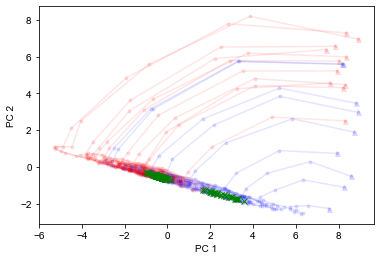

In [42]:
# 获取1000个64维的固定点
fixedpoints = hidden.detach().numpy()

# 类似之前的操作，绘制前20个试次的delay阶段的2维PC空间表征
plt.figure()
for i in range(20):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 1 else 'blue'
    plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
             color=color, ms=3, alpha=0.1)
    plt.plot(activity_pc[0, 0], activity_pc[0, 1], marker='^',
             color=color, ms=5, alpha=0.1)

# 绘制计算得到的200个固定点
fixedpoints_pc = pca.transform(fixedpoints)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', color='green')

plt.xlabel('PC 1')
plt.ylabel('PC 2')

# 对不同刺激条件分别绘制神经活动图

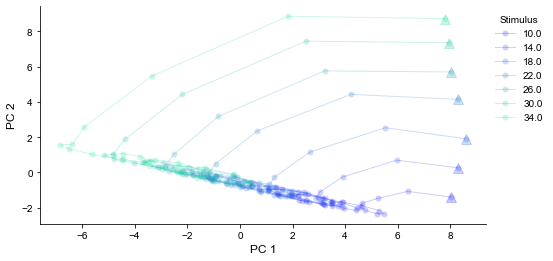

In [45]:
import pandas as pd
import matplotlib as mpl

# 将trial信息转成pandas格式
df = pd.DataFrame()
for i in range(len(trial_infos)):
    df = df.append(trial_infos[i], ignore_index=True)

#colors = np.array([[27,158,119], [117,112,179], [217,95,2]])/255.
# Search for two trials with similar conditions
values = np.unique(df['v1'])
color_intensity = [0.4, 0.7, 1.0, 1.3]
cmap = mpl.cm.get_cmap('winter') 
alpha = 0.2

for i, val in enumerate(values):
    trials = df[df['v1']==val].index
    activity = np.mean(np.array([activity_dict[i] for i in trials]), axis=0)

    activity_pc = pca.transform(activity)
    label = '{:0.1f}'.format(val)
    color = cmap(i/len(values))
    plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
            color=color, ms=6, markeredgecolor='none',
            lw=1, label=label, alpha=alpha)
    plt.plot(activity_pc[0, 0], activity_pc[0, 1], alpha=alpha,
            marker='^', color=color, ms=10)

#fixedpoints_pc = pca.transform(fixedpoints)
#plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', ms=8, color="r", alpha=0.3)

fig = plt.gcf()
fig.set_size_inches(8, 4)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(title='Stimulus', loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)

plt.xlabel('PC 1', fontsize=12)
plt.ylabel('PC 2', fontsize=12)

plt.show()